In [1]:
import sys
if sys.version_info[0] < 3:
    raise Exception("Python 3 not detected.")
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from scipy import io
import random
from sklearn.svm import SVC
random.seed(189)
np.random.seed(189)


In [6]:
import numpy as np

# Load MNIST Data
mnist_data = np.load("../data/mnist-data-hw3.npz")
training_data = mnist_data["training_data"]
training_labels = mnist_data["training_labels"].reshape(-1)  # Ensure labels are 1D

# Ensure Proper Flattening
if training_data.ndim == 4:
    training_data = training_data.squeeze(1)  # Remove singleton dimension
training_data = training_data.reshape(training_data.shape[0], -1)  # Flatten to (60000, 784)

# Debug: Check the first few pixel values
print("First 10 pixel values of the first image:", training_data[0, :10])

# Fix Contrast Normalization
def contrast_normalize(X, eps=1e-8):
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms[norms < eps] = eps  # Avoid zero division
    return X / norms

training_data_normed = contrast_normalize(training_data)

# Compute Mean and Covariance for Each Digit Class
digit_classes = np.unique(training_labels)
means = {}
covariances = {}

for digit in digit_classes:
    idx = training_labels == digit
    X_digit = training_data_normed[idx]  # Extract images of this class
    
    # Debug: Check how many samples per class
    print(f"Class {digit}: {X_digit.shape[0]} samples")

    # Compute Mean and Covariance
    mean_digit = np.mean(X_digit, axis=0)  # shape (784,)
    means[digit] = mean_digit
    cov_digit = np.cov(X_digit, rowvar=False)  # shape (784, 784)
    covariances[digit] = cov_digit

# Print Results
for digit in digit_classes:
    print(f"Digit: {digit}")
    print("Mean vector shape:", means[digit].shape)
    print("Covariance matrix shape:", covariances[digit].shape)
    print("First 5 elements of the mean vector:", means[digit][:5])
    print("Full Mean Vector:", means[digit])  # Now checking full mean vector
    print("-" * 40)


First 10 pixel values of the first image: [0 0 0 0 0 0 0 0 0 0]
Class 0: 5923 samples
Class 1: 6742 samples
Class 2: 5993 samples
Class 3: 6162 samples
Class 4: 5862 samples
Class 5: 5428 samples
Class 6: 5870 samples
Class 7: 6213 samples
Class 8: 5851 samples
Class 9: 5956 samples
Digit: 0
Mean vector shape: (784,)
Covariance matrix shape: (784, 784)
First 5 elements of the mean vector: [0. 0. 0. 0. 0.]
Full Mean Vector: [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

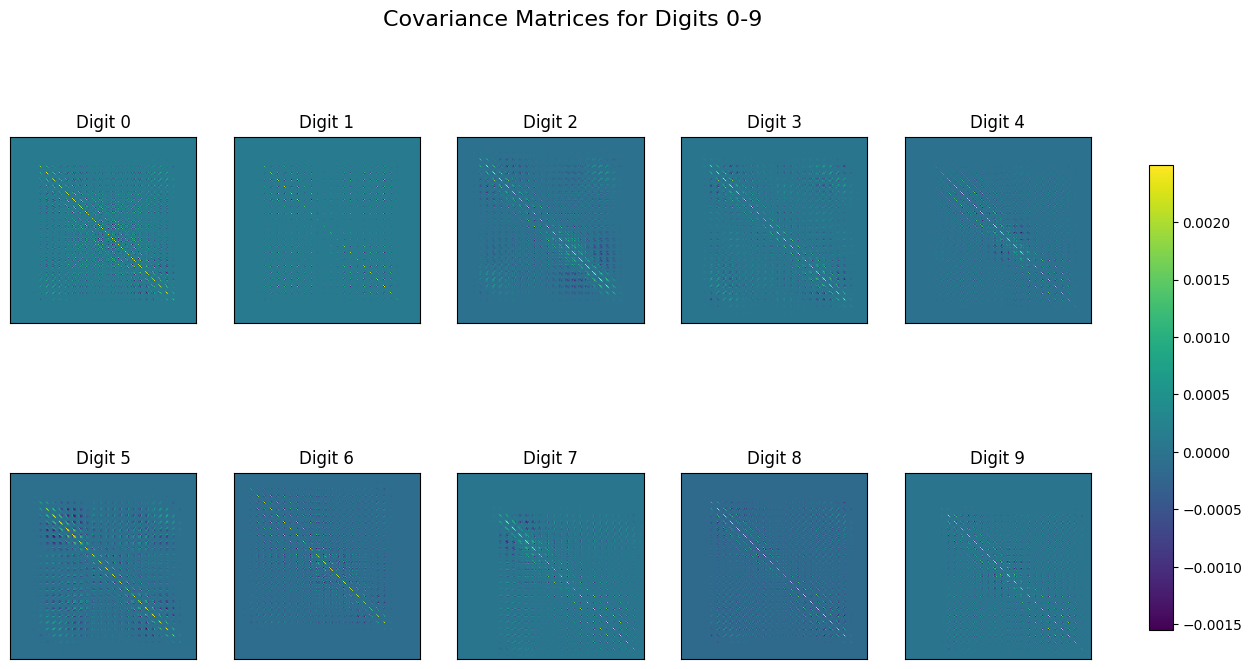

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

for i, digit in enumerate(digit_classes):  # Iterate over all digit classes
    ax = axes[i // 5, i % 5]  # Arrange in a 2x5 grid
    cov_matrix = covariances[digit]  # Extract covariance for this digit
    im = ax.imshow(cov_matrix, cmap='viridis', interpolation='nearest')
    ax.set_title(f"Digit {digit}")
    ax.set_xticks([])
    ax.set_yticks([])

# Add a colorbar to the right
fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02)
plt.suptitle("Covariance Matrices for Digits 0-9", fontsize=16)
plt.show()


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(189)
np.random.seed(189)

# Load your MNIST data (already flattened & shuffled, or do so if needed)
mnist_data = np.load("../data/mnist-data-hw3.npz")

def shuffle_partition_MNIST(data):
    training_data = data["training_data"].reshape(-1, 28 * 28)
    training_labels = data["training_labels"].reshape(-1, 1)
    combined_data = np.hstack((training_data, training_labels))

    np.random.shuffle(combined_data)
    validation_data = combined_data[:10000, :-1]  
    validation_labels = combined_data[:10000, -1]  
    training_data = combined_data[10000:, :-1]  
    training_labels = combined_data[10000:, -1]  

    return validation_data, validation_labels, training_data, training_labels

mnist_validation_data, mnist_validation_labels, mnist_training_data, mnist_training_labels = shuffle_partition_MNIST(mnist_data)
print("after process") 
print("MNIST Training Data Shape:", mnist_training_data.shape)
print("MNIST Validation Data Shape:", mnist_validation_data.shape)

after process
MNIST Training Data Shape: (50000, 784)
MNIST Validation Data Shape: (10000, 784)


In [11]:
def train_lda(X, y):
    """
    Train LDA on data X (N,d) with labels y (N,).
    Returns:
      pi_c  : (C,) array of class priors
      mu_c  : (C, d) array of class means
      Sigma : (d, d) shared covariance matrix
      classes : sorted list/array of unique class labels
    """
    classes = np.unique(y)
    C = len(classes)
    N, d = X.shape
    
    pi_c = np.zeros(C)
    mu_c = np.zeros((C, d))
    
    # 1) Compute priors & means
    for i, c in enumerate(classes):
        Xc = X[y == c]
        pi_c[i] = len(Xc) / float(N)
        mu_c[i] = np.mean(Xc, axis=0)
    
    # 2) Compute shared covariance
    Sigma = np.zeros((d, d))
    for i, c in enumerate(classes):
        Xc = X[y == c]
        for x in Xc:
            diff = (x - mu_c[i]).reshape(-1,1)
            Sigma += diff @ diff.T
    Sigma /= float(N)
    
    return pi_c, mu_c, Sigma, classes


In [12]:
def predict_lda(X, pi_c, mu_c, Sigma, classes):
    """
    Predict class labels for X using LDA parameters.
    X: (N,d)
    pi_c: (C,)
    mu_c: (C,d)
    Sigma: (d,d)
    classes: list/array of class labels
    Returns: y_pred (N,)
    """
    import numpy.linalg as LA
    # Use pseudo-inverse to handle singular covariance
    Sigma_inv = LA.pinv(Sigma)
    
    C = len(classes)
    N, d = X.shape
    y_pred = np.zeros(N, dtype=classes.dtype)
    
    # Precompute for speed (we skip constants that are same for all classes)
    for i in range(N):
        x = X[i]
        posteriors = []
        for j, c in enumerate(classes):
            diff = x - mu_c[j]
            # log-likelihood (ignoring constants)
            log_lik = -0.5 * diff @ Sigma_inv @ diff
            # log-prior
            log_prior = np.log(pi_c[j])
            posteriors.append(log_lik + log_prior)
        idx_best = np.argmax(posteriors)
        y_pred[i] = classes[idx_best]
    
    return y_pred


Training size=100, Error Rate=0.3314
Training size=200, Error Rate=0.3114
Training size=500, Error Rate=0.6618
Training size=1000, Error Rate=0.3421
Training size=2000, Error Rate=0.2170
Training size=5000, Error Rate=0.1587
Training size=10000, Error Rate=0.1423
Training size=30000, Error Rate=0.1334
Training size=50000, Error Rate=0.1303


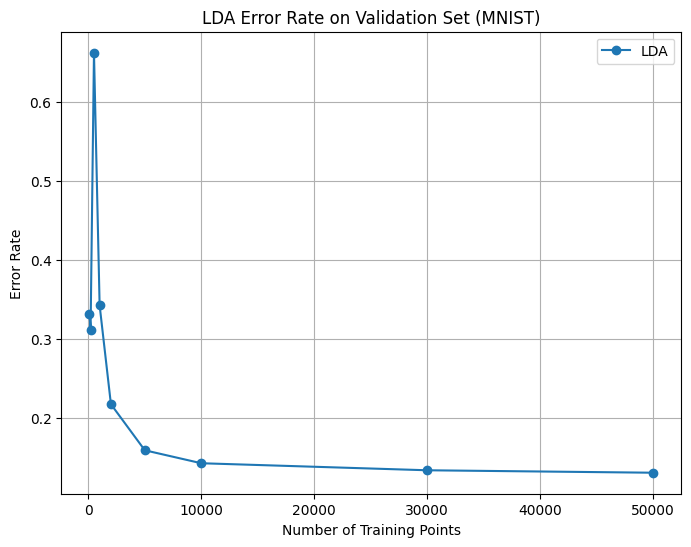

In [14]:
subset_sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
error_rates = []
for size in subset_sizes:
    # Pick the first `size` samples from X_train_full
    X_sub = mnist_training_data[:size]
    y_sub = mnist_training_labels[:size]
    
    # Train LDA
    pi_c, mu_c, Sigma, classes = train_lda(X_sub, y_sub)
    
    # Predict on validation set
    y_val_pred = predict_lda(mnist_validation_data, pi_c, mu_c, Sigma, classes)
    
    # Compute error rate
    accuracy = np.mean(y_val_pred == mnist_validation_labels)
    error_rate = 1.0 - accuracy
    error_rates.append(error_rate)
    
    print(f"Training size={size}, Error Rate={error_rate:.4f}")
    
plt.figure(figsize=(8,6))
plt.plot(subset_sizes, error_rates, marker='o', label='LDA')
plt.xlabel("Number of Training Points")
plt.ylabel("Error Rate")
plt.title("LDA Error Rate on Validation Set (MNIST)")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(189)
np.random.seed(189)

# Load MNIST dataset
mnist_data = np.load("../data/mnist-data-hw3.npz")

# Shuffle and split dataset
def shuffle_partition_MNIST(data):
    training_data = data["training_data"].reshape(-1, 28 * 28)
    training_labels = data["training_labels"].reshape(-1, 1)
    combined_data = np.hstack((training_data, training_labels))

    np.random.shuffle(combined_data)
    validation_data = combined_data[:10000, :-1]  
    validation_labels = combined_data[:10000, -1]  
    training_data = combined_data[10000:, :-1]  
    training_labels = combined_data[10000:, -1]  

    return validation_data, validation_labels, training_data, training_labels

mnist_validation_data, mnist_validation_labels, mnist_training_data, mnist_training_labels = shuffle_partition_MNIST(mnist_data)

print("after process") 
print("MNIST Training Data Shape:", mnist_training_data.shape)
print("MNIST Validation Data Shape:", mnist_validation_data.shape)

def train_qda(X, y):
    """
    Train QDA on data X (N,d) with labels y (N,).
    Returns:
      pi_c   : (C,) array of class priors
      mu_c   : (C, d) array of class means
      Sigma_c: (C, d, d) array of class covariance matrices
      classes: sorted list/array of unique class labels
    """
    classes = np.unique(y)
    C = len(classes)
    N, d = X.shape
    
    pi_c = np.zeros(C)
    mu_c = np.zeros((C, d))
    Sigma_c = np.zeros((C, d, d))
    
    # Compute priors & means
    for i, c in enumerate(classes):
        Xc = X[y == c]
        pi_c[i] = len(Xc) / float(N)
        mu_c[i] = np.mean(Xc, axis=0)
        # Compute covariance per class
        cov = np.cov(Xc, rowvar=False)
        Sigma_c[i] = cov + 1e-4 * np.eye(d)  # Regularization

    return pi_c, mu_c, Sigma_c, classes


after process
MNIST Training Data Shape: (50000, 784)
MNIST Validation Data Shape: (10000, 784)


In [16]:
def predict_qda(X, pi_c, mu_c, Sigma_c, classes):
    """
    Predict class labels for X using QDA parameters.
    X: (N,d)
    pi_c: (C,)
    mu_c: (C,d)
    Sigma_c: (C,d,d)
    classes: list/array of class labels
    Returns: y_pred (N,)
    """
    import numpy.linalg as LA
    C = len(classes)
    N, d = X.shape
    y_pred = np.zeros(N, dtype=classes.dtype)
    
    for i in range(N):
        x = X[i]
        posteriors = []
        for j, c in enumerate(classes):
            Sigma_inv = LA.pinv(Sigma_c[j])  # Use pseudo-inverse
            diff = x - mu_c[j]
            log_det = np.log(LA.det(Sigma_c[j]) + 1e-8)  # Avoid log(0)
            log_lik = -0.5 * (diff @ Sigma_inv @ diff + log_det)
            log_prior = np.log(pi_c[j])
            posteriors.append(log_lik + log_prior)
        idx_best = np.argmax(posteriors)
        y_pred[i] = classes[idx_best]
    
    return y_pred


subset_sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
error_rates_qda = []

for size in subset_sizes:
    X_sub = mnist_training_data[:size]
    y_sub = mnist_training_labels[:size]
    
    # Train QDA
    pi_c, mu_c, Sigma_c, classes = train_qda(X_sub, y_sub)
    
    # Predict on validation set
    y_val_pred = predict_qda(mnist_validation_data, pi_c, mu_c, Sigma_c, classes)
    
    # Compute error rate
    accuracy = np.mean(y_val_pred == mnist_validation_labels)
    error_rate = 1.0 - accuracy
    error_rates_qda.append(error_rate)
    
    print(f"Training size={size}, QDA Error Rate={error_rate:.4f}")

# Plot error rate vs training size
plt.figure(figsize=(8,6))
plt.plot(subset_sizes, error_rates_qda, marker='o', label='QDA', color='red')
plt.xlabel("Number of Training Points")
plt.ylabel("Error Rate")
plt.title("QDA Error Rate on Validation Set (MNIST)")
plt.legend()
plt.grid(True)
plt.show()


KeyboardInterrupt: 

In [17]:
import numpy as np
import random
import pandas as pd

random.seed(189)
np.random.seed(189)

# Load MNIST dataset
mnist_data = np.load("../data/mnist-data-hw3.npz")

# Extract training and test data
X_train = mnist_data["training_data"].reshape(-1, 28 * 28)
y_train = mnist_data["training_labels"]
X_test = mnist_data["test_data"].reshape(-1, 28 * 28)  # Test set

print("Training Data Shape:", X_train.shape)
print("Training Labels Shape:", y_train.shape)
print("Test Data Shape:", X_test.shape)

# Train LDA on the full dataset
def train_lda(X, y):
    """
    Train LDA on data X (N,d) with labels y (N,).
    Returns:
      pi_c  : (C,) array of class priors
      mu_c  : (C, d) array of class means
      Sigma : (d, d) shared covariance matrix
      classes : sorted list/array of unique class labels
    """
    classes = np.unique(y)
    C = len(classes)
    N, d = X.shape
    
    pi_c = np.zeros(C)
    mu_c = np.zeros((C, d))
    
    # Compute priors & means
    for i, c in enumerate(classes):
        Xc = X[y == c]
        pi_c[i] = len(Xc) / float(N)
        mu_c[i] = np.mean(Xc, axis=0)
    
    # Compute shared covariance
    Sigma = np.zeros((d, d))
    for i, c in enumerate(classes):
        Xc = X[y == c]
        for x in Xc:
            diff = (x - mu_c[i]).reshape(-1,1)
            Sigma += diff @ diff.T
    Sigma /= float(N)
    
    return pi_c, mu_c, Sigma, classes

# Train LDA on entire dataset
pi_c, mu_c, Sigma, classes = train_lda(X_train, y_train)

# Predict on test data
def predict_lda(X, pi_c, mu_c, Sigma, classes):
    """
    Predict class labels for X using LDA parameters.
    X: (N,d)
    pi_c: (C,)
    mu_c: (C,d)
    Sigma: (d,d)
    classes: list/array of class labels
    Returns: y_pred (N,)
    """
    import numpy.linalg as LA
    Sigma_inv = LA.pinv(Sigma)  # Use pseudo-inverse
    
    C = len(classes)
    N, d = X.shape
    y_pred = np.zeros(N, dtype=classes.dtype)
    
    for i in range(N):
        x = X[i]
        posteriors = []
        for j, c in enumerate(classes):
            diff = x - mu_c[j]
            log_lik = -0.5 * diff @ Sigma_inv @ diff
            log_prior = np.log(pi_c[j])
            posteriors.append(log_lik + log_prior)
        idx_best = np.argmax(posteriors)
        y_pred[i] = classes[idx_best]
    
    return y_pred

# Generate test set predictions
mnist_test_predictions = predict_lda(X_test, pi_c, mu_c, Sigma, classes)

import pandas as pd
def results_to_csv(y_test, file_name):
    y_test = y_test.astype(int)  
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  
    df.to_csv(file_name, index_label='Id')
# Save the predictions

results_to_csv(mnist_test_predictions, "mnist_submission_lda.csv")

print("LDA model trained on full dataset & predictions saved!")


Training Data Shape: (60000, 784)
Training Labels Shape: (60000,)
Test Data Shape: (10000, 784)
LDA model trained on full dataset & predictions saved!


In [18]:
%run featurize.py

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load SPAM dataset
spam_data = np.load("../data/new-spam-data.npz")
training_data = spam_data["training_data"]
training_labels = spam_data["training_labels"]

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    training_data, training_labels, test_size=0.2, random_state=42
)

print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Validation labels shape: {y_val.shape}")


Training data shape: (3336, 58), Training labels shape: (3336,)
Validation data shape: (835, 58), Validation labels shape: (835,)


LDA Error Rate on SPAM Validation Set: 0.2036
Training size=100, Error Rate=0.2515
Training size=200, Error Rate=0.2048
Training size=500, Error Rate=0.1928
Training size=1000, Error Rate=0.2036
Training size=2000, Error Rate=0.1976
Training size=3336, Error Rate=0.2036


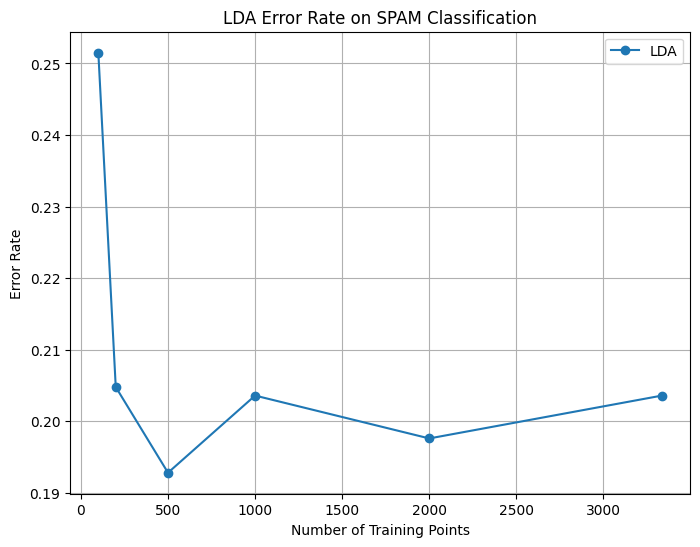

In [21]:
def train_lda(X, y):
    """
    Train LDA on data X with labels y.
    Returns:
      - pi_c : (C,) array of class priors
      - mu_c : (C, d) array of class means
      - Sigma: (d, d) shared covariance matrix
      - classes: List of unique class labels
    """
    classes = np.unique(y)
    C = len(classes)
    N, d = X.shape

    pi_c = np.zeros(C)
    mu_c = np.zeros((C, d))
    
    # Compute priors & means
    for i, c in enumerate(classes):
        Xc = X[y == c]  # Filter class-specific samples
        pi_c[i] = len(Xc) / float(N)
        mu_c[i] = np.mean(Xc, axis=0)

    # Compute shared covariance matrix
    Sigma = np.zeros((d, d))
    for i, c in enumerate(classes):
        Xc = X[y == c]
        for x in Xc:
            diff = (x - mu_c[i]).reshape(-1,1)
            Sigma += diff @ diff.T
    Sigma /= float(N)

    return pi_c, mu_c, Sigma, classes


def predict_lda(X, pi_c, mu_c, Sigma, classes):
    """
    Predict class labels for X using LDA parameters.
    Returns: y_pred (N,)
    """
    import numpy.linalg as LA
    Sigma_inv = LA.pinv(Sigma)  # Use pseudo-inverse in case of singularity

    C = len(classes)
    N, d = X.shape
    y_pred = np.zeros(N, dtype=classes.dtype)

    for i in range(N):
        x = X[i]
        posteriors = []
        for j, c in enumerate(classes):
            diff = x - mu_c[j]
            log_lik = -0.5 * diff @ Sigma_inv @ diff  # Log-likelihood
            log_prior = np.log(pi_c[j])  # Log prior
            posteriors.append(log_lik + log_prior)
        idx_best = np.argmax(posteriors)
        y_pred[i] = classes[idx_best]

    return y_pred


# Train LDA Model
pi_c, mu_c, Sigma, classes = train_lda(X_train, y_train)

# Predict on validation set
y_val_pred = predict_lda(X_val, pi_c, mu_c, Sigma, classes)

# Compute error rate
accuracy = np.mean(y_val_pred == y_val)
error_rate = 1.0 - accuracy

print(f"LDA Error Rate on SPAM Validation Set: {error_rate:.4f}")


subset_sizes = [100, 200, 500, 1000, 2000, len(X_train)]
error_rates = []

for size in subset_sizes:
    X_sub = X_train[:size]
    y_sub = y_train[:size]

    # Train LDA
    pi_c, mu_c, Sigma, classes = train_lda(X_sub, y_sub)

    # Predict
    y_val_pred = predict_lda(X_val, pi_c, mu_c, Sigma, classes)

    # Compute error rate
    accuracy = np.mean(y_val_pred == y_val)
    error_rate = 1.0 - accuracy
    error_rates.append(error_rate)

    print(f"Training size={size}, Error Rate={error_rate:.4f}")

plt.figure(figsize=(8,6))
plt.plot(subset_sizes, error_rates, marker='o', label='LDA')
plt.xlabel("Number of Training Points")
plt.ylabel("Error Rate")
plt.title("LDA Error Rate on SPAM Classification")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
import numpy as np
import pandas as pd

# Load SPAM dataset
spam_data = np.load("../data/new-spam-data.npz")
training_data = spam_data["training_data"]
training_labels = spam_data["training_labels"]
test_data = spam_data["test_data"]  # Load test data for final predictions

print(f"Full Training Data Shape: {training_data.shape}, Labels Shape: {training_labels.shape}")
print(f"Test Data Shape: {test_data.shape}")

# Train LDA on the entire dataset
pi_c, mu_c, Sigma, classes = train_lda(training_data, training_labels)

# Predict on test data
test_predictions = predict_lda(test_data, pi_c, mu_c, Sigma, classes)

print(f"Test Predictions Shape: {test_predictions.shape}")
results_to_csv(test_predictions, "spam_submission.csv")



Full Training Data Shape: (4171, 58), Labels Shape: (4171,)
Test Data Shape: (1000, 58)
Test Predictions Shape: (1000,)
